**Using scikit-learn for classification** In this coding session, we will use the scikit-learn framework to explore different classification algorithms. You are strongly encouraged to use the [scikit-learn docs](https://scikit-learn.org/stable/) as a reference during this session. Most of the code here was taken from the [Machine Learning with PyTorch and Scikit-learn book's Github repo](https://github.com/rasbt/machine-learning-book/tree/main).

We'll start by loading in the Iris dataset once more. This time, we'll consider only the Petal length and Petal width features.

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[50:, [2, 3]]
y = iris.target[50:]

print('Class labels:', np.unique(y))

Class labels: [1 2]


**Best practice #1: train-test splits** One thing we didn't consider last time was the issue of splitting data into train and test sets. The idea here is that to get an idea of the generalization performance of a model, we can train on only a subset of the data and use the remaining data to assess generalization (more sophisticated versions of this idea split into three groups: train, valididate, and test). scikit-learn has convenient functionality for splitting data in this way.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y)

A word on the parameters here: first, the test_size parameter controls the number of data points that are held out for the test set (in this case, 30%). The random_state parameter is the random seed used to randomly split the data, and ensures the code is reproducible. And finally, the stratify parameter ensures that the train and test sets are split equally between the classes. This last issue is a best practice that is extremely important, since in many applications one class is significantly more rare than another (e.g. medical diagnoses for rare conditions).

We can check that the method did indeed split with the correct proportions as follows.

In [3]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [ 0 50 50]
Labels counts in y_train: [ 0 25 25]
Labels counts in y_test: [ 0 25 25]


**Best-practice #2: feature standarization.** Another important best-practice that we haven't talked about yet is that of feature normalization. This has various meanings, but one of the most important is that we transform the data so that it is mean zero and has identity covariance. The reason for this is that many algorithms (although not all) are sensitive to the *scale* of the data. For example, if we are doing linear regression and one of the covariates has naturally much larger domain than another (e.g. income vs. age) then it would influence the outcome of the regression to an excessive degree.
Feature standarization means we take data $\mathcal{X} = (x_1, \ldots, x_n) \in (\mathbb{R}^d)^n$ and transform it to
$$
\mathcal{X}_{\mathrm{std}} = (Ax_1 + b, Ax_2 + b, \ldots, Ax_n + b) \in (\mathbb{R}^d)^n
$$ where $A \in \mathbb{R}^{d \times d}$ and $b \in \mathbb{R}^d$ are such that the transformed
data is **mean-zero** and **isotropic**, meaning that
$$
\sum_{x_{\mathrm{std}} \in \mathcal{X}_{\mathrm{std}}} x_{\mathrm{std}} = 0,
$$ and
$$
\sum_{x_{\mathrm{std}} \in \mathcal{X}_{\mathrm{std}}} x_{\mathrm{std}} x_{\mathrm{std}}^T = I_d.
$$

The following code uses scikit-learn to accomplish this. 

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
# NOTICE: we apply this same transformation to the test data. This
#       is a very important point that could be easy to forget!
X_test_std = sc.transform(X_test)

Now that we have prepared our data using the above two best-practices, we can get around to fitting some models with scikit-learn!

Let's start with the Perceptron. The following code initializes a Perceptron model and fits it to the training data. The careful reader will notice that we are running the Perceptron algorithm on data with more than $2$ classes. This is handled with a *one-vs.-all (OvA)* approach where we train one classifier for each class (which treats the class as positive examples and all others as negative) and then for new data points we choose the classifier with the highest confidence.

In [5]:
from sklearn.linear_model import Perceptron

# The random_state here is a seed to shuffle the training data, which
# we fix to make the output reproducible
ppn = Perceptron(random_state=1)

# This line fits the model with X_train_std as the feature data and
# y_train as the response data
ppn.fit(X_train_std, y_train)

Perceptron(random_state=1)

Notice the similarities between this call and the Perceptron class we implemented last time. Indeed, recall that the API that we implemented last time supported calls of the form `.fit(X, y)` as well as `.predict(X)`. The former fitted the model with input `X, y` and the latter computed predictions on new data `X`. This general structure is shared by much of the scikit-learn API, as we'll see repeatedly below.

In particular, we can compute predictions as follows.


In [6]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 3


We'll now plot the decision regions that this results in, using similar code to last time (and again, there's no need to look at this code in detail).

In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = np.array(('red', 'blue', 'lightgreen', 'gray', 'cyan'))
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')

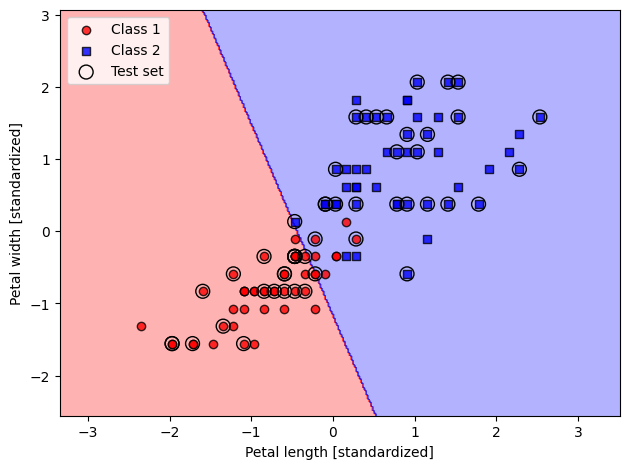

In [8]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(50, 100))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

We can also easily use an SVM model.

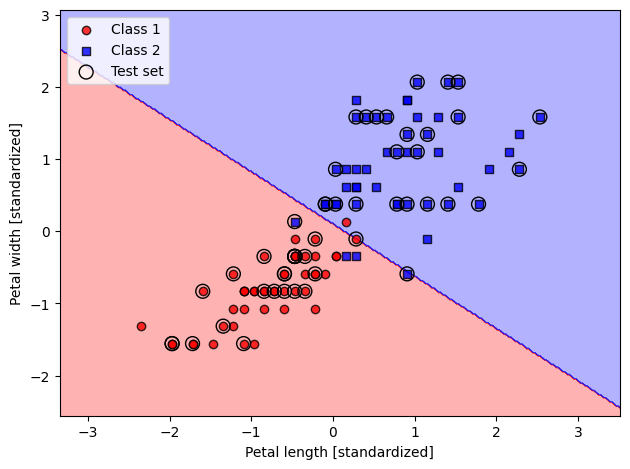

In [9]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(50, 100))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_11.png', dpi=300)
plt.show()

The following code creates a kernelized SVM with kernel $K(x, x') := e^{-\gamma \|x - x'\|^2}$, where $\gamma > 0$ is a parameter that controls the width of the kernel.

In [10]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.5)

Now, you will fit this model and plot its performance on the data.

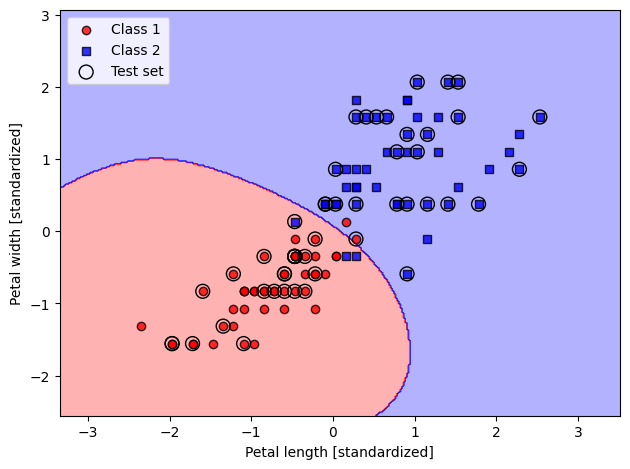

In [11]:
### YOUR CODE HERE ###

svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(50, 100))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_11.png', dpi=300)
plt.show()

Let's play also with the $\gamma$ parameter: create another SVM with a much larger $\gamma$ and plot the decision regions.

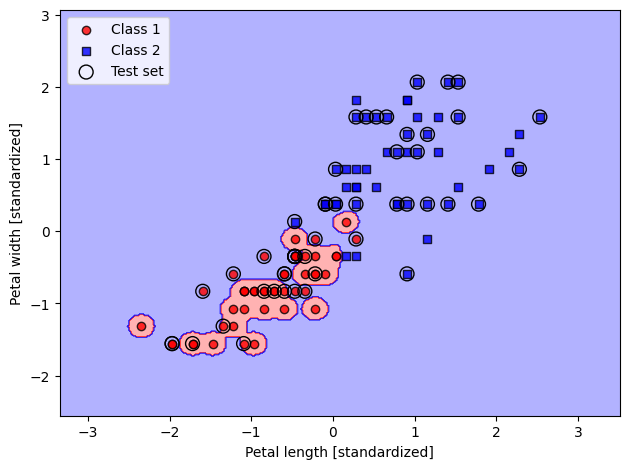

In [12]:
### YOUR CODE HERE ###

svm = SVC(kernel='rbf', random_state=1, gamma=100.0)

svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(50, 100))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_11.png', dpi=300)
plt.show()

Intuitively, why are the decision regions like they are for large $\gamma$? Do you think such a model would generalize well?

Next, we'll try a decision tree classifier. Notice that decision trees are not sensitive to the scale of the data, so we don't need to use the standardized data sets. 

In [1]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(50, 100))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'X_train' is not defined

**Implementing AdaBoost with decision stumps** Finally, we'll implement the AdaBoost algorithm with decision stumps. Recall that this algorithm assumes access to a weak learner that given any weight classification problem, returns a classifier that does slightly better than average.

- **Input:** $X \in \mathcal{X}^n$, $y \in \{-1, 1\}^n$, $T \in \mathbb{N}$
- Initialize $\mu^{(0)} = (1/n)_{i =1 }^n$
- For $t = 1, \ldots, T$:
    - Let $h_t$ be a weak learner for the data $(X, y)$ with
    weight vector $\mu^{(t)}$
    - Put $\varepsilon_t := \sum_{i = 1}^n \mu_i^{(t)} 1[h_t(x_i) \neq y_i]$
    -  Put $w_t := 
        (1/2) \log(1/\varepsilon_t - 1)$.
    - Set $\mu^{(t + 1/2)}_i := 
        \mu^{(t)}_i \cdot
        e^{-w_t y_i h_t(x_i)}$.
    - Let $\mu^{(t + 1)} := \mu^{(t + 1/2)}/\langle 1, 
        \mu^{(t + 1/2)} \rangle$.
- Return the weighted ensemble classifier
    $
 h_w \colon x \mapsto 
    \mathrm{sgn}\big( \sum_{ t= 1}^T
    w_t h_t(x) \big).
    $

For the purposes of our implementation, you may assume that the labels $y$ are always in $\{-1, 1\}$ (when we apply AdaBoost to the Iris dataset below we'll transform the data so this is true).


In [26]:
from sklearn.tree import DecisionTreeClassifier

def DecisionStumpLearner(X, y, mu):
    stump = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=1, 
                                    random_state=1)

    stump.fit(X, y, mu)

    return stump

class AdaBoost:
    def __init__(self, T, weak_learner=DecisionStumpLearner):
        self.T = T
        self.weak_learner = weak_learner

    def fit(self, X, y):
        n = np.shape(X)[0]
        self.w = np.zeros(self.T)
        
        mu = np.ones(n)/n
        self.learners = []

        for t in range(0, self.T):
            h = self.weak_learner(X, y, mu)
            self.learners.append(h)
            y_predict = h.predict(X)
            
            errors = np.where(y != y_predict, 1, 0)

            eps = np.dot(mu, errors)

            self.w[t] = 0.5*np.log(1./eps - 1.)

            mu = mu*np.array([np.exp(-self.w[t]*y[i]*y_predict[i]) for i in range(0, n)])

            mu = mu/mu.sum()


    def predict(self, X):
        return np.where(self.net_input(X) >= 0, 1, -1)

    def net_input(self, X):
        input = np.zeros(np.shape(X)[0])
        for t in range(0, self.T):
            input += self.w[t]*self.learners[t].predict(X)

        return input
    

Let's use this AdaBoost implementation and see what the decision regions look like.

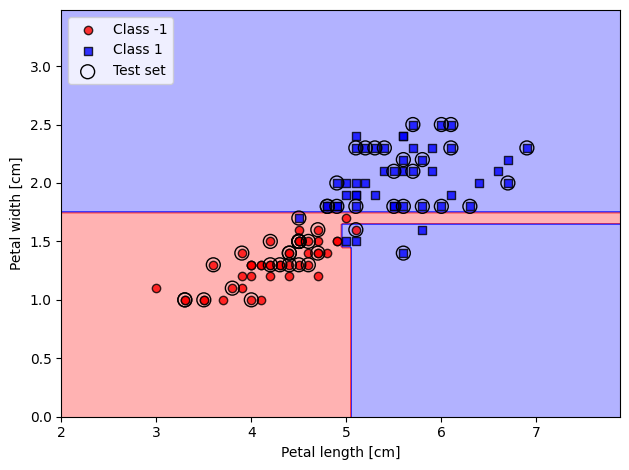

In [28]:
adaboost_clf = AdaBoost(20)

# let's first map label 2 to +1 and label 1 to -1 so
# we may apply our AdaBoost implementation
y_train_modified = np.where(y_train >= 1.5, 1, -1)
y_test_modified = np.where(y_test >= 1.5, 1, -1)

adaboost_clf.fit(X_train, y_train_modified)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train_modified, y_test_modified))
plot_decision_regions(X_combined, y_combined, 
                      classifier=adaboost_clf,
                      test_idx=range(50, 100))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Notice that AdaBoost can easily fit the training data to 0 error, which should give you some cause for concern. Indeed, AdaBoost is known to suffer from overfitting and so a conservative number of iterations, which may be selected by cross-validation, are recommended.

In [ ]:
            # mu = mu*np.array([np.exp(self.w[t]*(2*errors[i] - 1.)) for i in range(0, n)])

            # if eps == 0.:
            #     self.T = t + 1
            #     self.w = np.zeros(self.T)
            #     self.w[-1] = 1.
            #     return